# ALD Exploration

Max's analysis of different classifiers.

> Henry: I adapted the data loading to run it myself. Autoformatting was applied.

## Loading data

In [1]:
import pandas as pd
import os
import numpy as np
import sklearn
import sklearn.linear_model as skllm
import sklearn.ensemble as skle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FOLDER_DATA_RAW = 'data/raw'

annotation_file = pd.read_csv(os.path.join(
    FOLDER_DATA_RAW, 'Experiment annotation file.csv'), index_col=[0])
annotation_file_plasma = annotation_file[annotation_file['Sample type'] == 'Plasma']
annotation_file_plasma.index = pd.Index(
    annotation_file_plasma.index, dtype=int)

report_plasma = pd.read_csv(os.path.join(
    FOLDER_DATA_RAW, '20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv'), na_values='Filtered')
report_plasma.rename({'PG.Genes': 'Gene names',
                      'PG.ProteinAccessions': 'Protein ID'}, inplace=True, axis=1)
report_plasma.head()
columns_ = ['Protein ID', 'Gene names']
ids_ = report_plasma[columns_].apply(lambda series_: series_.str.split(';'))

experimental_columns = annotation_file_plasma['Sample ID']
report_plasma[columns_] = report_plasma[columns_].apply(
    lambda series_: series_.str.split(';').str[0])
map_filenames_ids = dict(
    zip(annotation_file['File name'], annotation_file['Sample ID']))

data_plasma_raw = report_plasma.copy()
data_plasma_raw.drop(data_plasma_raw.filter(
    regex='StrippedSequences').columns, axis=1, inplace=True)

data_plasma_raw = data_plasma_raw.rename(mapper=map_filenames_ids, axis=1)
IDmapping_UniprotID_to_Genename = dict(
    zip(data_plasma_raw['Protein ID'], data_plasma_raw['Gene names']))
data_plasma_raw = data_plasma_raw.set_index(
    'Protein ID').drop('Gene names', axis=1)

key_ProteinID = pd.read_csv(os.path.join(FOLDER_DATA_RAW, 'ID_matching_key.csv'),
                            index_col="Protein ID").drop("Unnamed: 0", axis=1)

### Clinical Data

In [3]:
DATAFOLDER = 'data/processed'
PROTEOM = 'data_ml_proteomics.csv'
CLINICAL = 'df_cli_164.csv'
COL_ID = 'Sample ID'
f_data_clinic = os.path.join(FOLDER_DATA_RAW, CLINICAL)
data_cli = pd.read_csv(f_data_clinic, index_col=COL_ID)
data_cli = data_cli[data_cli['kleiner'] != 0.5]

FEATURES_ML = ['nas_steatosis_ordinal', 'nas_inflam', 'kleiner',
               'fib4', 'elf', 'ft', 'te', 'swe', 'aar', 'ast',
               'apri', 'forns', 'm30', 'm65', 'meld', 'p3np', 'timp1', 'cap']

file_cutoff_clinic = "data/raw/clinical_marker_test_cut-offs.xlsx"
cutoffs_clinic = pd.read_excel(
    file_cutoff_clinic, sheet_name="cutoffs", index_col='marker')

markers_to_drop = []
for marker in cutoffs_clinic.index:
    if marker not in data_cli.columns:
        print(f"{marker}: Missing in clinics data.")
        markers_to_drop.append(marker)

if markers_to_drop:
    cutoffs_clinic.drop(labels=markers_to_drop, inplace=True)
cutoffs_clinic

proc3: Missing in clinics data.


,F2,F3,INFL2,steatosis
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


### Preprocessing

In [4]:
from helper import log2, imputation_normal_distribution

DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS = 200
CV_COEFFICIENT = 0.3

data_plasma_filtered = data_plasma_raw.dropna(
    axis=0, thresh=data_plasma_raw.shape[1] * DATA_COMPLETENESS)
data_plasma_filtered = data_plasma_filtered.dropna(
    axis=1, thresh=MIN_N_PROTEIN_GROUPS)
data_plasma_filtered_log = data_plasma_filtered.apply(log2)
data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(
    imputation_normal_distribution)

qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2']
                                   == 'QC']['Sample ID']
df_qc = data_plasma_filtered.copy()[qc_plasma]
def coef_of_variation(x): return np.std(x) / np.mean(x)


proteins_cv = df_qc.apply(coef_of_variation, axis=1)

cv_selected = proteins_cv < CV_COEFFICIENT

df_qc = df_qc.assign(cv=proteins_cv)
qc_30 = df_qc[cv_selected].index

df = data_plasma_filtered_log_imputed.copy()
df = df.rename_axis('Sample ID', axis=1).T
# filter proteins for CV < 30% of the inter-day/plate quality assessment
df_30 = df[qc_30]
data_proteomics = df_30

### Targets

In [5]:
from helper import create_dichotome

target_columns = ['kleiner', 'nas_steatosis_ordinal', 'nas_inflam']
Y = data_cli[target_columns]

kleiner_ge_2 = create_dichotome(Y['kleiner'], 2)
kleiner_ge_3 = create_dichotome(Y['kleiner'], 3)
steatosis_ge_1 = create_dichotome(Y['nas_steatosis_ordinal'], 1)
inflamation_ge_2 = create_dichotome(Y['nas_inflam'], 2)

## Feature Selection

In [6]:
from helper import FeatureSelector

feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
proteins_selected_f2 = feature_selected.fit(
    data_proteomics, kleiner_ge_2, 'F2')
proteins_selected_f3 = feature_selected.fit(
    data_proteomics, kleiner_ge_3, 'F3')
proteins_selected_s1 = feature_selected.fit(
    data_proteomics, steatosis_ge_1, 'S1')
proteins_selected_I2 = feature_selected.fit(
    data_proteomics, inflamation_ge_2, 'I2')

## Cross Validation of Model

In [7]:
test_cases = {}

test_cases['F2'] = {'proteins': proteins_selected_f2, 'y': kleiner_ge_2}
test_cases['F3'] = {'proteins': proteins_selected_f3, 'y': kleiner_ge_3}
test_cases['S1'] = {'proteins': proteins_selected_s1, 'y': steatosis_ge_1}
test_cases['I2'] = {'proteins': proteins_selected_I2, 'y': inflamation_ge_2}

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']
CV_FOLDS = 5
CV_REPEATS = 10

_clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

proteins_selected = proteins_selected_f2
y = kleiner_ge_2

_X = data_proteomics[proteins_selected.index]
in_both = y.index.intersection(_X.index)
_X = _X.loc[in_both]
_y = y.loc[in_both]

result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(
    n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0), scoring=scoring)

In [9]:
# Make sure the results are similar to the previous results

refvals = {}
refvals['test_precision'] = 0.832388
refvals['test_recall'] = 0.788949
refvals['test_f1'] = 0.808201
refvals['test_balanced_accuracy'] = 0.793597
refvals['test_roc_auc'] = 0.884170

mean_vals = np.round(pd.DataFrame(result).mean().to_frame().T, 3)

for key in refvals.keys():
    assert np.round(refvals[key], 3) == mean_vals[key][0]

## Check Model
Is there a model that outperforms logistic regression out of the box?

In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [11]:
# Try multiple optimizers and see what happens
fpath_results_classifier_comparison = os.path.join(
    DATAFOLDER, 'results_classifier_comparison.pkl')

try:
    grouped = pd.read_pickle(fpath_results_classifier_comparison)
except FileNotFoundError:

    from tqdm.notebook import tqdm as tqdm

    from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
    from xgboost import XGBClassifier

    MLA = [
        # Ensemble Methods
        ensemble.AdaBoostClassifier(),
        ensemble.BaggingClassifier(),
        ensemble.ExtraTreesClassifier(),
        ensemble.GradientBoostingClassifier(),
        ensemble.RandomForestClassifier(),

        # Gaussian Processes
        gaussian_process.GaussianProcessClassifier(),

        # GLM
        linear_model.LogisticRegressionCV(),
        linear_model.PassiveAggressiveClassifier(),
        linear_model.RidgeClassifierCV(),
        linear_model.SGDClassifier(),
        linear_model.Perceptron(),

        # Navies Bayes
        naive_bayes.BernoulliNB(),
        naive_bayes.GaussianNB(),

        # Nearest Neighbor
        neighbors.KNeighborsClassifier(),

        # SVM
        svm.SVC(probability=True),
        svm.NuSVC(probability=True),
        svm.LinearSVC(),

        # Trees
        tree.DecisionTreeClassifier(),
        tree.ExtraTreeClassifier(),

        # Discriminant Analysis
        discriminant_analysis.LinearDiscriminantAnalysis(),
        discriminant_analysis.QuadraticDiscriminantAnalysis(),


        # xgboost: http://xgboost.readthedocs.io/en/latest/model.html
        XGBClassifier()
    ]

    summary = []

    for model in tqdm(MLA):

        for test_case in test_cases.keys():

            proteins_selected = test_cases[test_case]['proteins']
            y = test_cases[test_case]['y']

            _X = data_proteomics[proteins_selected.index]
            in_both = y.index.intersection(_X.index)
            _X = _X.loc[in_both]
            _y = y.loc[in_both]

            result = cross_validate(model, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(
                n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0), scoring=scoring)
            result['name'] = model.__class__.__name__
            result['test_case'] = test_case

            summary.append(pd.DataFrame(result))

    print('Complete')
    summary_df = pd.concat(summary)
    grouped = summary_df.groupby(['name', 'test_case']).mean(
    ).sort_values(by=['test_case', 'test_f1'], ascending=False)
    grouped = grouped.reset_index()

    grouped.to_pickle(fpath_results_classifier_comparison)
grouped

,name,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
0,RidgeClassifierCV,S1,0.002764,0.005538,0.799308,0.849385,0.822579,0.787477,0.857775
1,LinearDiscriminantAnalysis,S1,0.002250,0.005333,0.801652,0.844756,0.821583,0.788056,0.858158
2,LogisticRegressionCV,S1,0.355163,0.004880,0.795031,0.840628,0.815644,0.779819,0.855829
3,SVC,S1,0.007298,0.005001,0.788848,0.816256,0.801156,0.767623,0.844418
4,NuSVC,S1,0.008709,0.005186,0.794314,0.810077,0.800942,0.770361,0.843495
...,...,...,...,...,...,...,...,...,...
83,ExtraTreeClassifier,F2,0.001500,0.004561,0.767728,0.742731,0.752359,0.727646,0.727646
84,LinearSVC,F2,0.008100,0.004704,0.821424,0.741051,0.740871,0.716977,0.883335
85,PassiveAggressiveClassifier,F2,0.001857,0.004613,0.807405,0.735179,0.715497,0.697096,0.884689
86,BernoulliNB,F2,0.001779,0.004862,0.555869,1.000000,0.714534,0.500000,0.500000


### Define a baseline: Logistic Regression

In [12]:
baseline = {}

for test_case in test_cases.keys():
    baseline[test_case] = grouped[(grouped['name'] == 'LogisticRegressionCV') & (
        grouped['test_case'] == test_case)].iloc[0]

cols = ['fit_time', 'score_time', 'test_precision', 'test_recall',
        'test_f1', 'test_balanced_accuracy', 'test_roc_auc']

In [13]:
grouped_norm = grouped.copy()

for i in range(len(grouped)):

    grouped_norm.loc[i,
                     cols] -= baseline[grouped_norm.loc[i, 'test_case']][cols]

### Best performing algorithms: F1, AUC

In [14]:
grouped_norm.sort_values(
    by='test_f1', ascending=False).groupby('test_case').head(1)

,name,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
44,GaussianNB,F3,-0.390352,-0.000157,-0.032544,0.113860,0.046307,0.045609,-0.011496
0,RidgeClassifierCV,S1,-0.352399,0.000657,0.004277,0.008756,0.006935,0.007658,0.001945
66,ExtraTreesClassifier,F2,-0.301201,0.013365,0.014443,-0.001051,0.006278,0.009827,0.008717
22,LogisticRegressionCV,I2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
grouped_norm.sort_values(
    by='test_roc_auc', ascending=False).groupby('test_case').head(1)

,name,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
66,ExtraTreesClassifier,F2,-0.301201,0.013365,0.014443,-0.001051,0.006278,0.009827,0.008717
6,RandomForestClassifier,S1,-0.242429,0.013253,0.013474,-0.057590,-0.021595,-0.008096,0.003453
47,RidgeClassifierCV,F3,-0.389202,0.000305,0.012376,0.009298,0.012088,0.007102,0.002954
25,SVC,I2,-0.288099,0.000543,0.026992,-0.039872,-0.009077,0.004515,0.001264


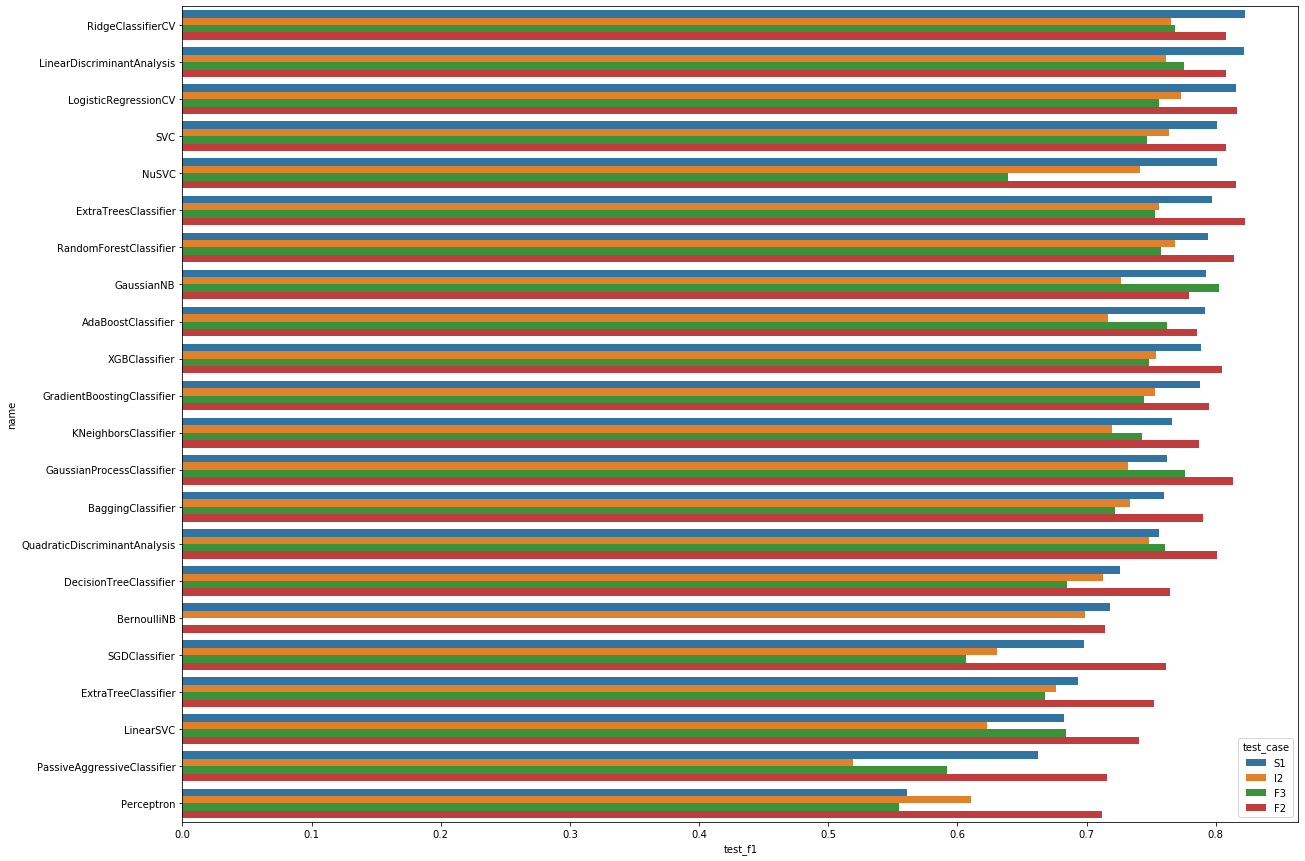

In [16]:
plt.figure(figsize=(20, 15))
sns.barplot(x='test_f1', y='name', hue='test_case', data=grouped)
plt.show()

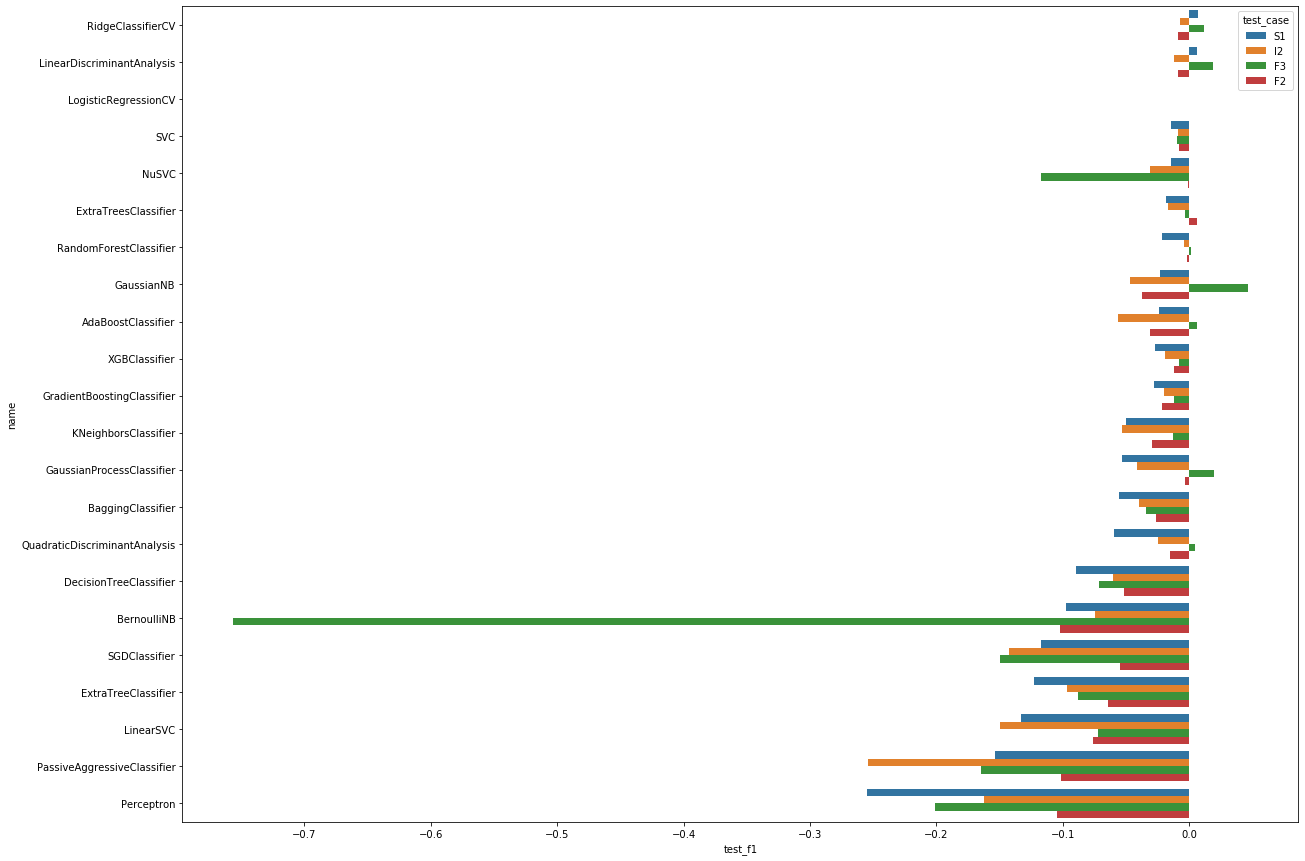

In [17]:
plt.figure(figsize=(20, 15))
sns.barplot(x='test_f1', y='name', hue='test_case', data=grouped_norm)
plt.show()

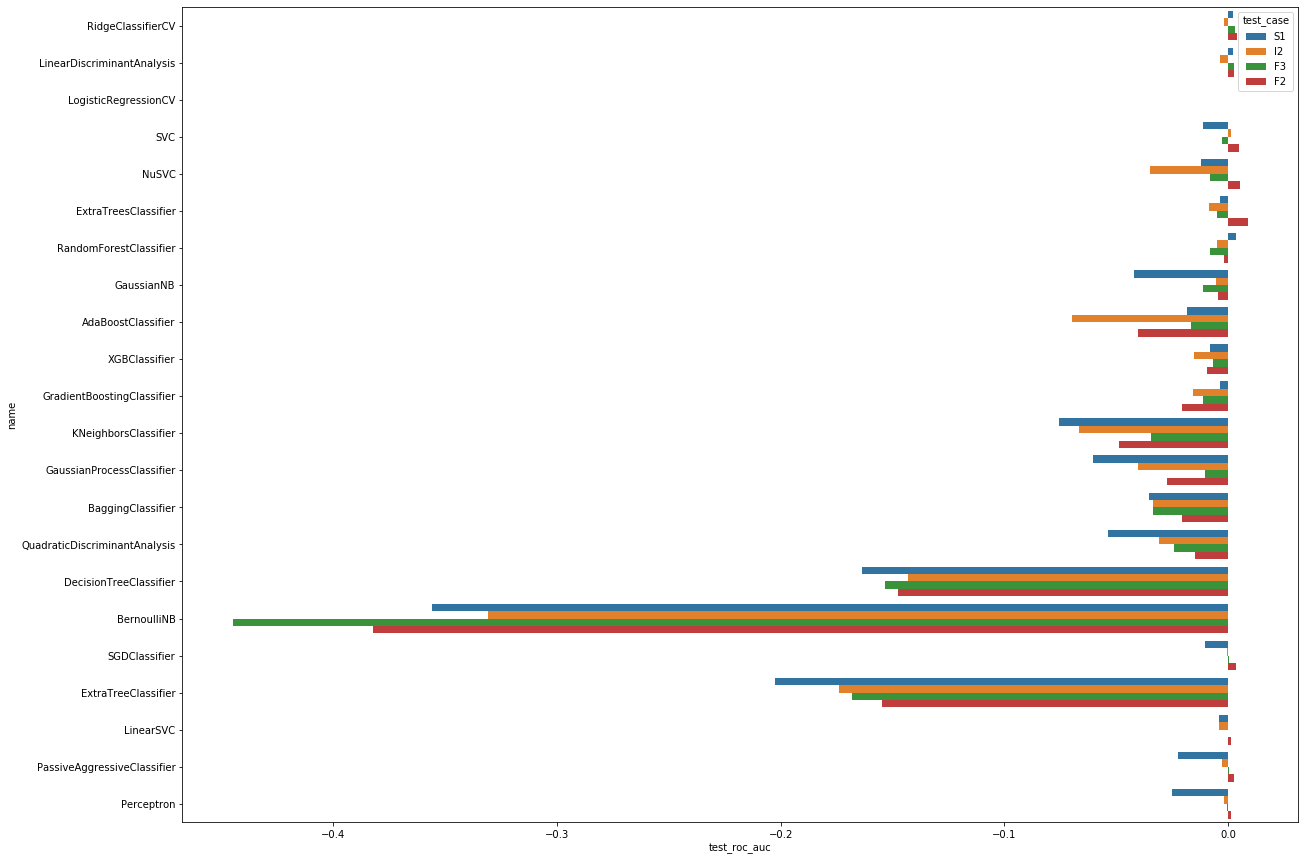

In [18]:
plt.figure(figsize=(20, 15))
sns.barplot(x='test_roc_auc', y='name', hue='test_case', data=grouped_norm)
plt.show()

## Can we optimize on the feature selection part?

Let's try a couple of things here: Are the numbers of features optimized?

In [19]:
feature_selection_comparison_cv = os.path.join(
        DATAFOLDER, 'feature_selection_comparison_cv.pkl')
try:
    summary = pd.read_pickle(feature_selection_comparison_cv)
except FileNotFoundError:
    summary = []

    for n_features in tqdm(range(1, 50)):

        feature_selected = FeatureSelector(
            k=n_features, protein_gene_data=key_ProteinID)
        proteins_selected_f2 = feature_selected.fit(
            data_proteomics, kleiner_ge_2, 'F2')
        proteins_selected_f3 = feature_selected.fit(
            data_proteomics, kleiner_ge_3, 'F3')
        proteins_selected_s1 = feature_selected.fit(
            data_proteomics, steatosis_ge_1, 'S1')
        proteins_selected_I2 = feature_selected.fit(
            data_proteomics, inflamation_ge_2, 'I2')

        test_cases = {}

        test_cases['F2'] = {
            'proteins': proteins_selected_f2, 'y': kleiner_ge_2}
        test_cases['F3'] = {
            'proteins': proteins_selected_f3, 'y': kleiner_ge_3}
        test_cases['S1'] = {
            'proteins': proteins_selected_s1, 'y': steatosis_ge_1}
        test_cases['I2'] = {
            'proteins': proteins_selected_I2, 'y': inflamation_ge_2}

        for test_case in test_cases.keys():
            _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

            proteins_selected = test_cases[test_case]['proteins']
            y = test_cases[test_case]['y']

            _X = data_proteomics[proteins_selected.index]
            in_both = y.index.intersection(_X.index)
            _X = _X.loc[in_both]
            _y = y.loc[in_both]

            result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(
                n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0), scoring=scoring)

            result['name'] = _clf.__class__.__name__
            result['n_features'] = n_features
            result['test_case'] = test_case

            summary.append(pd.DataFrame(result))

    summary = pd.concat(summary)
    summary.to_pickle(feature_selection_comparison_cv)

In [20]:
summary

,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc,name,n_features,test_case
0,0.002998,0.004004,0.582090,0.975000,0.728972,0.550000,0.861719,LogisticRegression,1,F2
1,0.001001,0.005000,0.606061,1.000000,0.754717,0.593750,0.822656,LogisticRegression,1,F2
2,0.000998,0.005025,0.565217,0.975000,0.715596,0.518750,0.826563,LogisticRegression,1,F2
3,0.001002,0.005000,0.571429,1.000000,0.727273,0.516129,0.908065,LogisticRegression,1,F2
4,0.000998,0.005000,0.573529,1.000000,0.728972,0.546875,0.927885,LogisticRegression,1,F2
...,...,...,...,...,...,...,...,...,...,...
45,0.004000,0.006000,0.783784,0.783784,0.783784,0.770680,0.899263,LogisticRegression,49,I2
46,0.003000,0.006025,0.690476,0.783784,0.734177,0.694922,0.762490,LogisticRegression,49,I2
47,0.003974,0.005002,0.789474,0.789474,0.789474,0.769737,0.826480,LogisticRegression,49,I2
48,0.003000,0.005001,0.718750,0.605263,0.657143,0.662007,0.755757,LogisticRegression,49,I2


In [21]:
combined = summary.groupby(['test_case', 'n_features']).mean()

combined.sort_values(by='test_f1', ascending=False).groupby(
    'test_case').head(1)

,,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
test_case,n_features,,,,,,,
S1,36,0.002948,0.005041,0.835592,0.834154,0.833322,0.810410,0.890522
F3,21,0.002591,0.004791,0.878523,0.788012,0.828084,0.874383,0.961464
F2,14,0.002099,0.004861,0.850198,0.807103,0.826781,0.813955,0.884219
I2,9,0.001990,0.004721,0.782882,0.767553,0.772661,0.757290,0.831072


In [22]:
combined.sort_values(by='test_roc_auc', ascending=False).groupby(
    'test_case').head(1)

,,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
test_case,n_features,,,,,,,
F3,20,0.002680,0.005021,0.869148,0.783567,0.821609,0.870652,0.961602
S1,32,0.002766,0.005034,0.833306,0.830077,0.830121,0.807060,0.892083
F2,5,0.001961,0.004822,0.837322,0.774372,0.802823,0.791631,0.886718
I2,7,0.001821,0.004605,0.775388,0.765462,0.767896,0.751320,0.832451


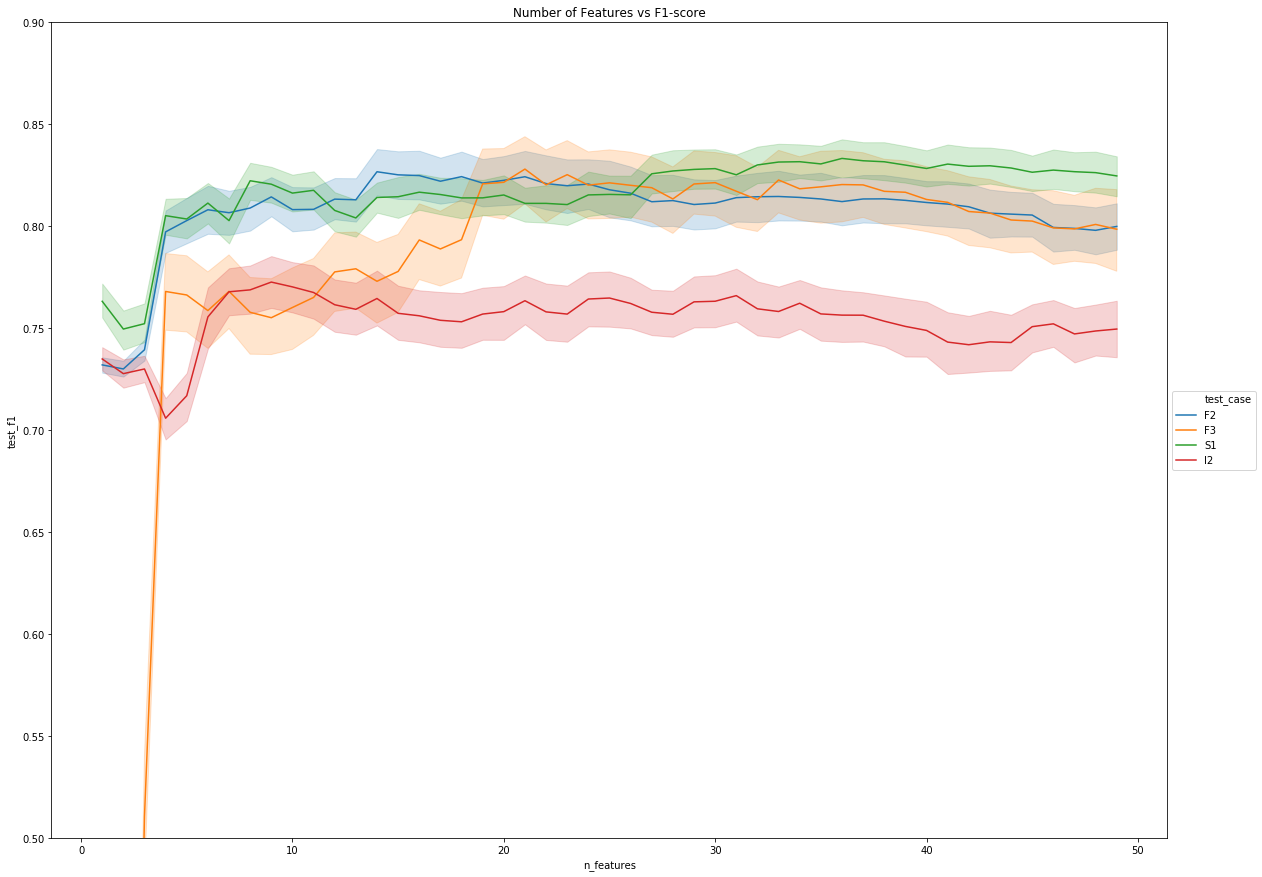

In [23]:
plt.figure(figsize=(20, 15))
sns.lineplot(x='n_features', y='test_f1', hue='test_case', data=summary)
plt.ylim([0.5, 0.9])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Features vs F1-score')
plt.show()

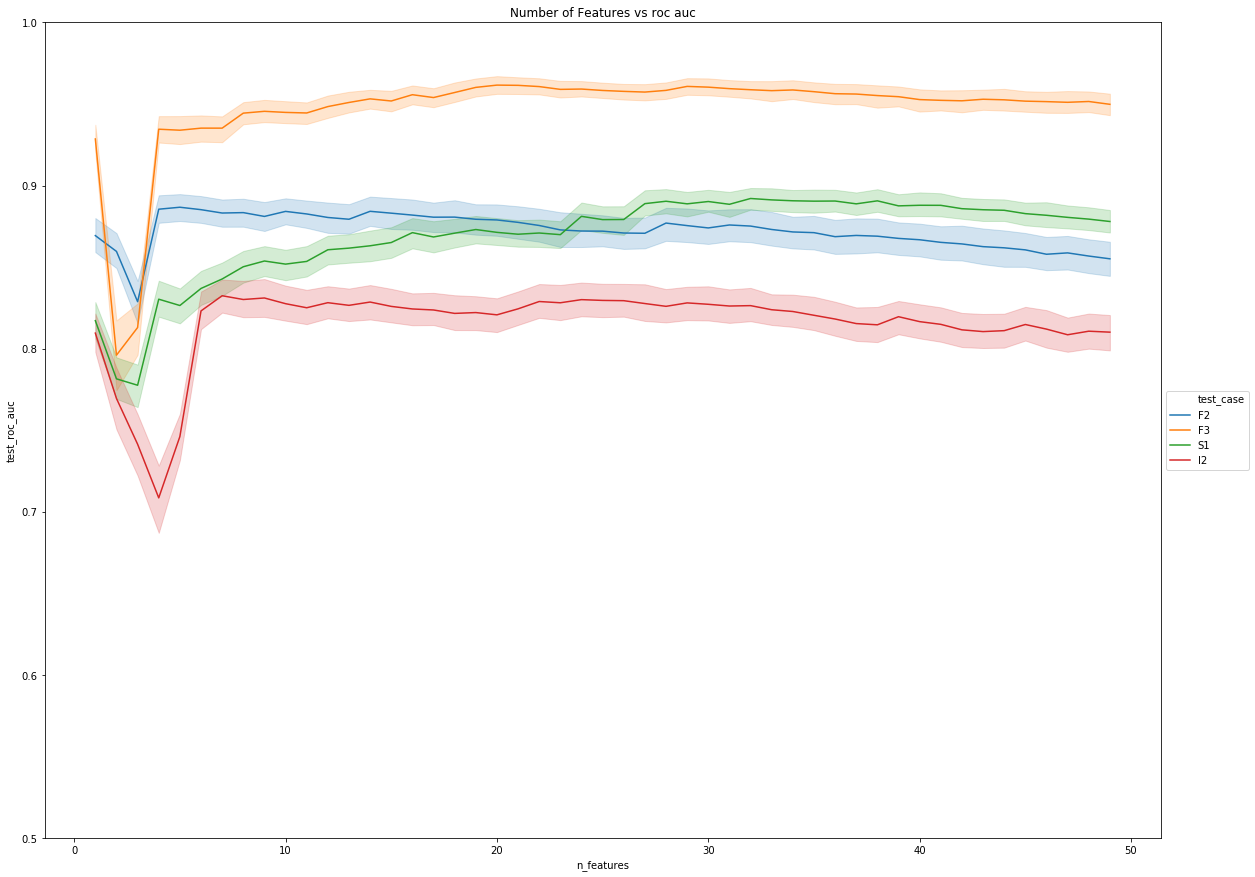

In [24]:
plt.figure(figsize=(20, 15))
sns.lineplot(x='n_features', y='test_roc_auc', hue='test_case', data=summary)
plt.ylim([0.5, 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Features vs roc auc')
plt.show()

## Decision tree based feature selection

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel


def get_features_dt(X, y, dummy):

    mask_samples_in_both = X.index.intersection(y.index)
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X.loc[mask_samples_in_both], y.loc[mask_samples_in_both])
    clf.feature_importances_

    indices = np.argsort(clf.feature_importances_)[::-1]

    return X.columns[indices]


proteins_selected_f2 = get_features_dt(data_proteomics, kleiner_ge_2, 'F2')
proteins_selected_f3 = get_features_dt(data_proteomics, kleiner_ge_3, 'F3')
proteins_selected_s1 = get_features_dt(data_proteomics, steatosis_ge_1, 'S1')
proteins_selected_I2 = get_features_dt(data_proteomics, inflamation_ge_2, 'I2')

test_cases = {}

test_cases['F2'] = {'proteins': proteins_selected_f2, 'y': kleiner_ge_2}
test_cases['F3'] = {'proteins': proteins_selected_f3, 'y': kleiner_ge_3}
test_cases['S1'] = {'proteins': proteins_selected_s1, 'y': steatosis_ge_1}
test_cases['I2'] = {'proteins': proteins_selected_I2, 'y': inflamation_ge_2}

decision_tree_feature_selection = os.path.join(
    DATAFOLDER, 'decision_tree_feature_selection.pkl')

try:
    combind_dt = pd.read_pickle(decision_tree_feature_selection)
except FileNotFoundError:
    summary = []

    for n_features in tqdm(range(1, 50)):

        for test_case in test_cases.keys():
            _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

            proteins_selected = test_cases[test_case]['proteins']
            y = test_cases[test_case]['y']

            _X = data_proteomics[proteins_selected[:n_features]]
            in_both = y.index.intersection(_X.index)
            _X = _X.loc[in_both]
            _y = y.loc[in_both]

            result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(
                n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0), scoring=scoring)

            result['name'] = _clf.__class__.__name__
            result['n_features'] = n_features
            result['test_case'] = test_case

            summary.append(pd.DataFrame(result))
    combind_dt = pd.concat(summary)
    combind_dt.to_pickle(decision_tree_feature_selection)

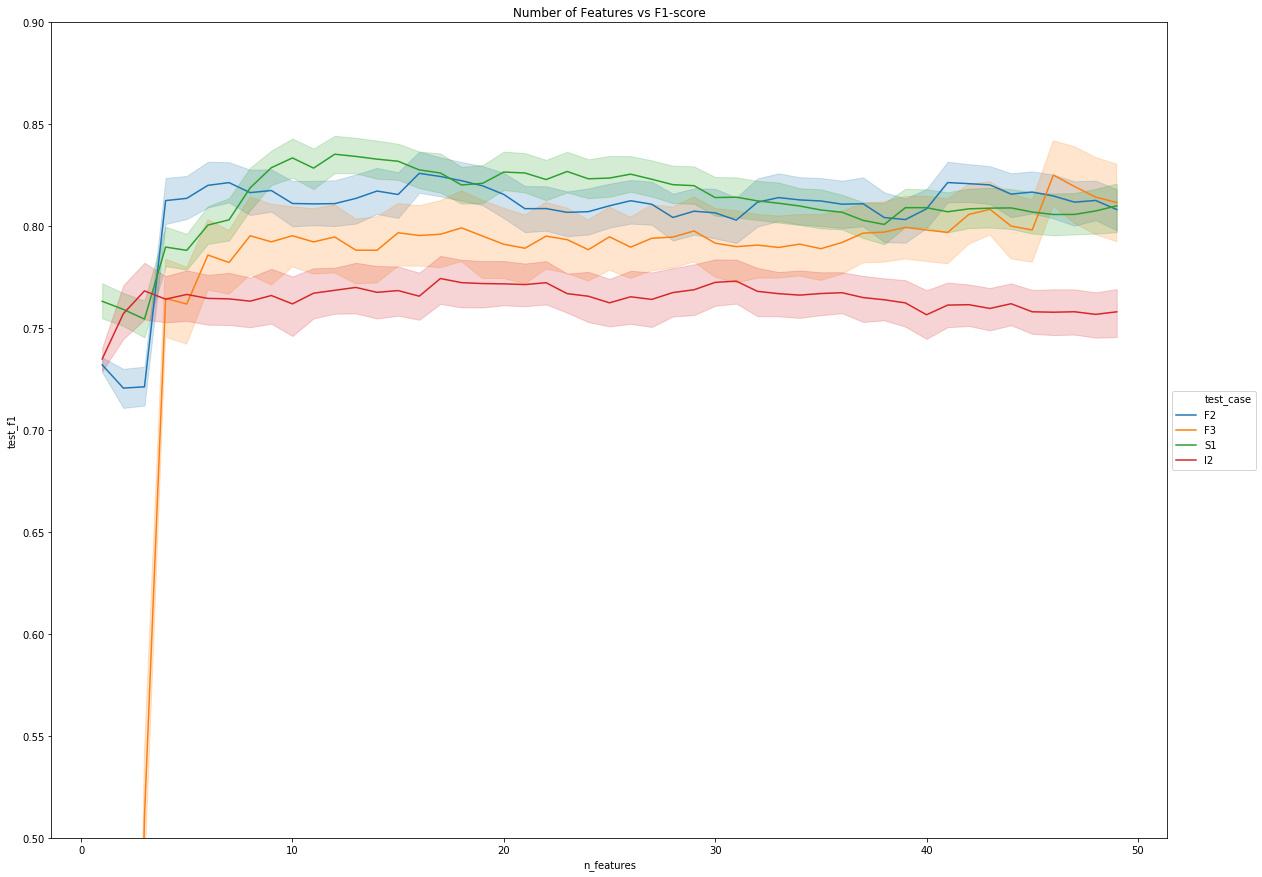

In [26]:
plt.figure(figsize=(20, 15))
sns.lineplot(x='n_features', y='test_f1', hue='test_case', data=combind_dt)
plt.ylim([0.5, 0.9])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Features vs F1-score')
plt.show()

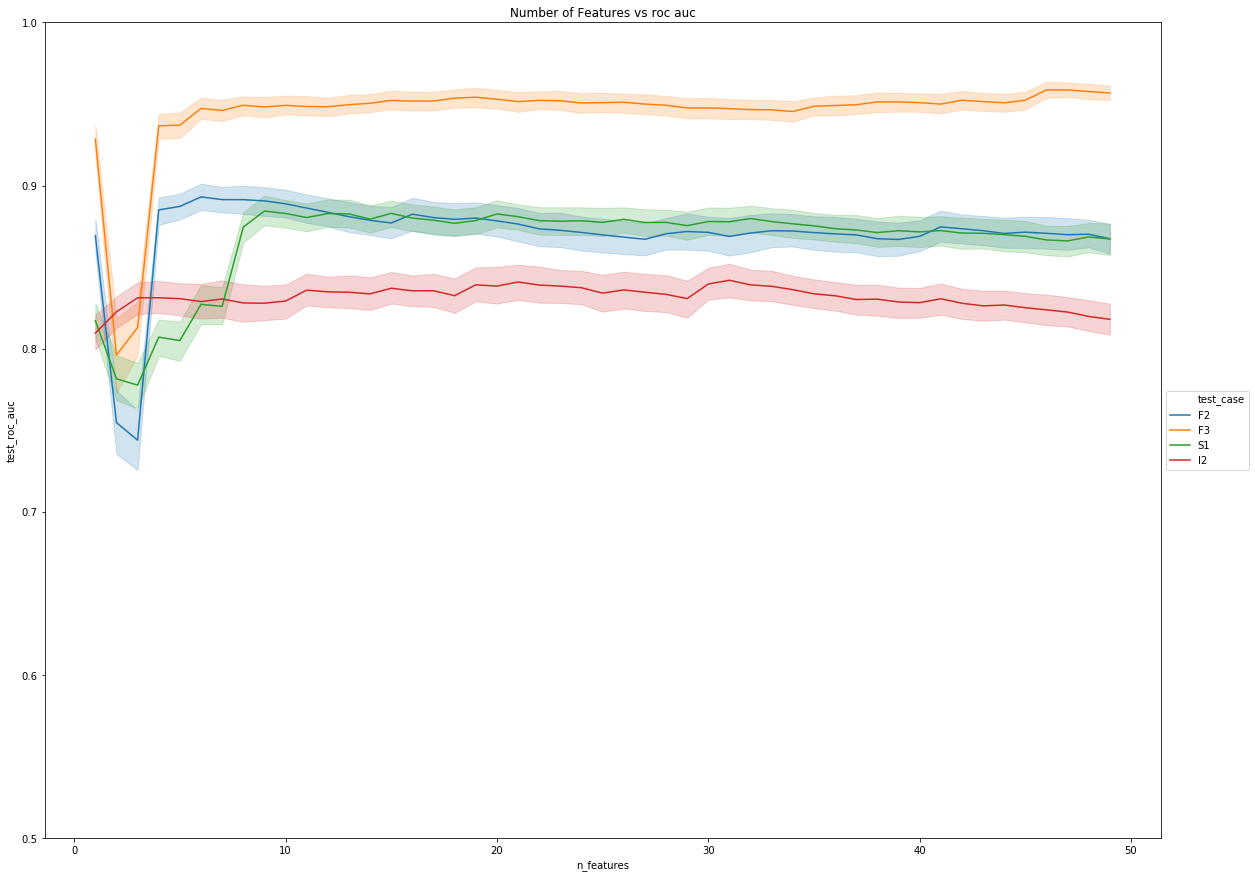

In [27]:
plt.figure(figsize=(20, 15))
sns.lineplot(x='n_features', y='test_roc_auc',
             hue='test_case', data=combind_dt)
plt.ylim([0.5, 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Features vs roc auc')
plt.show()

In [28]:
feature_selected = FeatureSelector(k=5, protein_gene_data=key_ProteinID)
proteins_selected_f2 = feature_selected.fit(
    data_proteomics, kleiner_ge_2, 'F2')

feature_selected = FeatureSelector(k=20, protein_gene_data=key_ProteinID)
proteins_selected_f3 = feature_selected.fit(
    data_proteomics, kleiner_ge_3, 'F3')

feature_selected = FeatureSelector(k=32, protein_gene_data=key_ProteinID)
proteins_selected_s1 = feature_selected.fit(
    data_proteomics, steatosis_ge_1, 'S1')

feature_selected = FeatureSelector(k=7, protein_gene_data=key_ProteinID)
proteins_selected_I2 = feature_selected.fit(
    data_proteomics, inflamation_ge_2, 'I2')

test_cases = {}

test_cases['F2'] = {'proteins': proteins_selected_f2, 'y': kleiner_ge_2}
test_cases['F3'] = {'proteins': proteins_selected_f3, 'y': kleiner_ge_3}
test_cases['S1'] = {'proteins': proteins_selected_s1, 'y': steatosis_ge_1}
test_cases['I2'] = {'proteins': proteins_selected_I2, 'y': inflamation_ge_2}

In [29]:
# Try multiple optimizers and see what happens

from tqdm.notebook import tqdm as tqdm

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),

    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    # Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),

    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),


    # xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()
]

summary = []


for model in tqdm(MLA):

    for test_case in test_cases.keys():

        proteins_selected = test_cases[test_case]['proteins']
        y = test_cases[test_case]['y']

        _X = data_proteomics[proteins_selected.index]
        in_both = y.index.intersection(_X.index)
        _X = _X.loc[in_both]
        _y = y.loc[in_both]

        result = cross_validate(model, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(
            n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0), scoring=scoring)
        result['name'] = model.__class__.__name__
        result['test_case'] = test_case

        summary.append(pd.DataFrame(result))

print('Complete')

  0%|          | 0/22 [00:00<?, ?it/s]

C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\met

Complete


In [30]:
summary_df = pd.concat(summary)
grouped = summary_df.groupby(['name', 'test_case']).mean(
).sort_values(by=['test_case', 'test_f1'], ascending=False)
grouped = grouped.reset_index()
grouped

grouped_norm = grouped.copy()

for i in range(len(grouped)):

    grouped_norm.loc[i,
                     cols] -= baseline[grouped_norm.loc[i, 'test_case']][cols]

In [31]:
grouped_norm.sort_values(
    by='test_f1', ascending=False).groupby('test_case').head(1)

,name,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
44,LinearDiscriminantAnalysis,F3,-0.389593,0.000197,0.030770,0.090819,0.066142,0.048617,0.015359
0,RandomForestClassifier,S1,-0.230375,0.013283,0.041375,0.010346,0.026551,0.038044,0.046104
22,RandomForestClassifier,I2,-0.185805,0.013404,0.001287,0.010597,0.005052,0.003963,-0.000742
66,LinearDiscriminantAnalysis,F2,-0.377163,0.000307,0.034439,-0.029051,-0.000601,0.011281,0.003863


In [32]:
grouped_norm.sort_values(
    by='test_roc_auc', ascending=False).groupby('test_case').head(1)

,name,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
0,RandomForestClassifier,S1,-0.230375,0.013283,0.041375,0.010346,0.026551,0.038044,0.046104
57,LinearSVC,F3,-0.383252,-0.000200,-0.002569,0.061988,-0.000964,0.011938,0.015649
31,GaussianNB,I2,-0.294367,-0.000248,0.058493,-0.080967,-0.019693,0.008910,0.012058
72,SVC,F2,-0.373112,0.000289,0.035192,-0.063282,-0.020523,-0.002740,0.006807


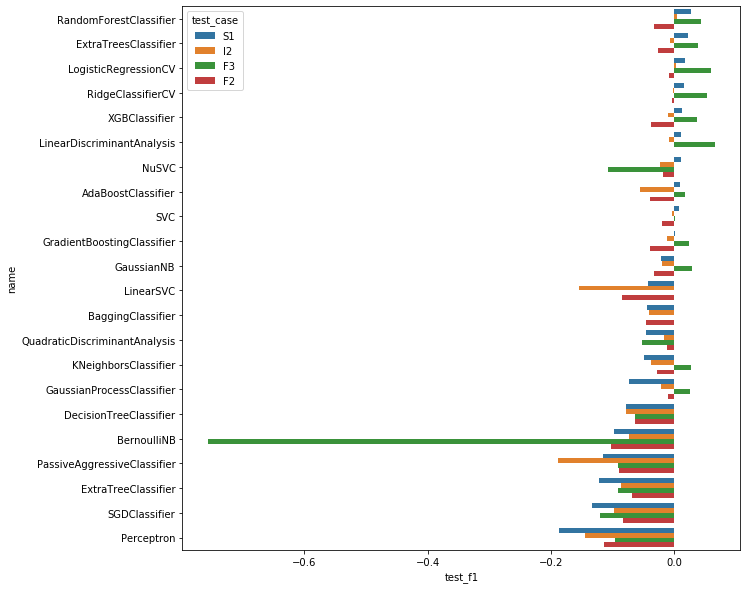

In [33]:
plt.figure(figsize=(10, 10))
sns.barplot(x='test_f1', y='name', hue='test_case', data=grouped_norm)
plt.show()

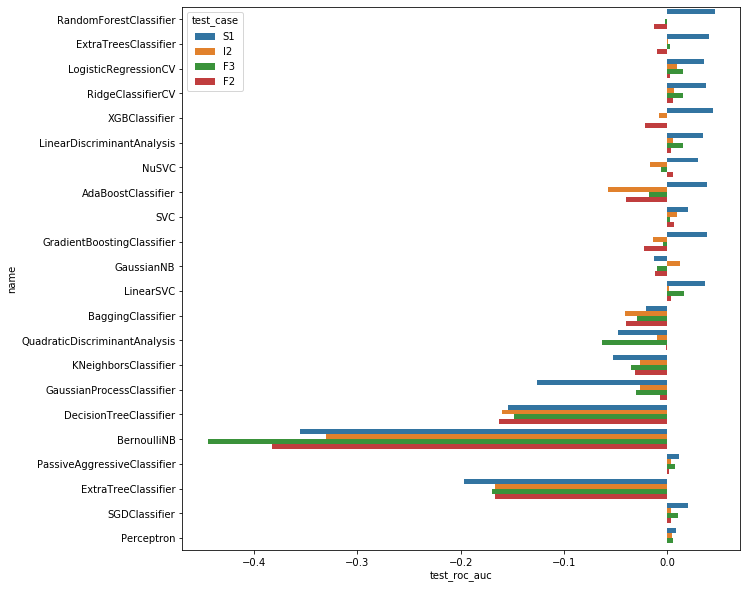

In [34]:
plt.figure(figsize=(10, 10))
sns.barplot(x='test_roc_auc', y='name', hue='test_case', data=grouped_norm)
plt.show()

## Missing value imputation ? / Preprocesisng

### CV

In [35]:
from helper import log2, imputation_normal_distribution

summary = []

for CV_COEFFICIENT in tqdm(np.linspace(0.2, 0.5, 10)):

    DATA_COMPLETENESS = 0.6
    MIN_N_PROTEIN_GROUPS = 200
    #CV_COEFFICIENT = 0.3

    data_plasma_filtered = data_plasma_raw.dropna(
        axis=0, thresh=data_plasma_raw.shape[1] * DATA_COMPLETENESS)
    data_plasma_filtered = data_plasma_filtered.dropna(
        axis=1, thresh=MIN_N_PROTEIN_GROUPS)
    data_plasma_filtered_log = data_plasma_filtered.apply(log2)
    data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(
        imputation_normal_distribution)

    qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2']
                                       == 'QC']['Sample ID']
    df_qc = data_plasma_filtered.copy()[qc_plasma]
    def coef_of_variation(x): return np.std(x) / np.mean(x)
    proteins_cv = df_qc.apply(coef_of_variation, axis=1)

    cv_selected = proteins_cv < CV_COEFFICIENT

    df_qc = df_qc.assign(cv=proteins_cv)
    qc_30 = df_qc[cv_selected].index

    df = data_plasma_filtered_log_imputed.copy()
    df = df.rename_axis('Sample ID', axis=1).T
    # filter proteins for CV < 30% of the inter-day/plate quality assessment
    df_30 = df[qc_30]
    data_proteomics = df_30

    feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
    proteins_selected_f2 = feature_selected.fit(
        data_proteomics, kleiner_ge_2, 'F2')
    proteins_selected_f3 = feature_selected.fit(
        data_proteomics, kleiner_ge_3, 'F3')
    proteins_selected_s1 = feature_selected.fit(
        data_proteomics, steatosis_ge_1, 'S1')
    proteins_selected_I2 = feature_selected.fit(
        data_proteomics, inflamation_ge_2, 'I2')

    test_cases = {}

    test_cases['F2'] = {'proteins': proteins_selected_f2, 'y': kleiner_ge_2}
    test_cases['F3'] = {'proteins': proteins_selected_f3, 'y': kleiner_ge_3}
    test_cases['S1'] = {'proteins': proteins_selected_s1, 'y': steatosis_ge_1}
    test_cases['I2'] = {
        'proteins': proteins_selected_I2, 'y': inflamation_ge_2}

    for test_case in test_cases.keys():
        _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

        proteins_selected = test_cases[test_case]['proteins']
        y = test_cases[test_case]['y']

        _X = data_proteomics[proteins_selected.index]
        in_both = y.index.intersection(_X.index)
        _X = _X.loc[in_both]
        _y = y.loc[in_both]

        result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(
            n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0), scoring=scoring)

        result['name'] = _clf.__class__.__name__
        result['CV'] = CV_COEFFICIENT
        result['test_case'] = test_case

        summary.append(pd.DataFrame(result))

combined = pd.concat([pd.DataFrame(_).groupby(
    'test_case').mean() for _ in summary])
combined = combined.reset_index()

combined.sort_values(by=['test_case', 'test_f1'],
                     ascending=False).groupby('test_case').head(3)

  0%|          | 0/10 [00:00<?, ?it/s]

,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc,CV
6,S1,0.001859,0.004580,0.796570,0.849436,0.821154,0.785148,0.856808,0.233333
10,S1,0.002177,0.005212,0.796570,0.849436,0.821154,0.785148,0.856808,0.266667
14,S1,0.001920,0.004660,0.794839,0.841244,0.816307,0.780740,0.851838,0.300000
7,I2,0.001856,0.004592,0.780870,0.764410,0.770306,0.755103,0.827576,0.233333
11,I2,0.001841,0.004630,0.780870,0.764410,0.770306,0.755103,0.827576,0.266667
15,I2,0.001860,0.004580,0.780870,0.764410,0.770306,0.755103,0.827576,0.300000
1,F3,0.001960,0.004520,0.821301,0.716374,0.760866,0.829697,0.944718,0.200000
5,F3,0.001980,0.004591,0.818404,0.714971,0.760191,0.828995,0.944867,0.233333
9,F3,0.001950,0.004611,0.818404,0.714971,0.760191,0.828995,0.944867,0.266667
0,F2,0.001942,0.004518,0.838568,0.789449,0.811881,0.798525,0.882061,0.200000


* no big difference

In [36]:
from helper import log2, imputation_normal_distribution

summary = []

for DATA_COMPLETENESS in tqdm(np.linspace(0.4, 0.8, 20)):

    #DATA_COMPLETENESS = 0.6
    MIN_N_PROTEIN_GROUPS = 200
    CV_COEFFICIENT = 0.3

    data_plasma_filtered = data_plasma_raw.dropna(
        axis=0, thresh=data_plasma_raw.shape[1] * DATA_COMPLETENESS)
    data_plasma_filtered = data_plasma_filtered.dropna(
        axis=1, thresh=MIN_N_PROTEIN_GROUPS)
    data_plasma_filtered_log = data_plasma_filtered.apply(log2)
    data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(
        imputation_normal_distribution)

    qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2']
                                       == 'QC']['Sample ID']
    df_qc = data_plasma_filtered.copy()[qc_plasma]
    def coef_of_variation(x): return np.std(x) / np.mean(x)
    proteins_cv = df_qc.apply(coef_of_variation, axis=1)

    cv_selected = proteins_cv < CV_COEFFICIENT

    df_qc = df_qc.assign(cv=proteins_cv)
    qc_30 = df_qc[cv_selected].index

    df = data_plasma_filtered_log_imputed.copy()
    df = df.rename_axis('Sample ID', axis=1).T
    # filter proteins for CV < 30% of the inter-day/plate quality assessment
    df_30 = df[qc_30]
    data_proteomics = df_30

    feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
    proteins_selected_f2 = feature_selected.fit(
        data_proteomics, kleiner_ge_2, 'F2')
    proteins_selected_f3 = feature_selected.fit(
        data_proteomics, kleiner_ge_3, 'F3')
    proteins_selected_s1 = feature_selected.fit(
        data_proteomics, steatosis_ge_1, 'S1')
    proteins_selected_I2 = feature_selected.fit(
        data_proteomics, inflamation_ge_2, 'I2')

    test_cases = {}

    test_cases['F2'] = {'proteins': proteins_selected_f2, 'y': kleiner_ge_2}
    test_cases['F3'] = {'proteins': proteins_selected_f3, 'y': kleiner_ge_3}
    test_cases['S1'] = {'proteins': proteins_selected_s1, 'y': steatosis_ge_1}
    test_cases['I2'] = {
        'proteins': proteins_selected_I2, 'y': inflamation_ge_2}

    for test_case in test_cases.keys():
        _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

        proteins_selected = test_cases[test_case]['proteins']
        y = test_cases[test_case]['y']

        _X = data_proteomics[proteins_selected.index]
        in_both = y.index.intersection(_X.index)
        _X = _X.loc[in_both]
        _y = y.loc[in_both]

        result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(
            n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0), scoring=scoring)

        result['name'] = _clf.__class__.__name__
        result['DATA_COMPLETENESS'] = DATA_COMPLETENESS
        result['test_case'] = test_case

        summary.append(pd.DataFrame(result))

combined = pd.concat([pd.DataFrame(_).groupby(
    'test_case').mean() for _ in summary])
combined = combined.reset_index()

combined.sort_values(by=['test_case', 'test_f1'],
                     ascending=False).groupby('test_case').head(3)

  0%|          | 0/20 [00:00<?, ?it/s]

,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc,DATA_COMPLETENESS
62,S1,0.001992,0.004769,0.795187,0.856090,0.823510,0.786174,0.853604,0.715789
54,S1,0.002148,0.005189,0.794548,0.856603,0.823403,0.785785,0.853421,0.673684
50,S1,0.001846,0.004618,0.793748,0.856615,0.823018,0.785146,0.853321,0.652632
35,I2,0.001820,0.004600,0.797355,0.775064,0.783689,0.770335,0.831877,0.568421
7,I2,0.001920,0.004720,0.797325,0.772959,0.782607,0.769595,0.831991,0.421053
11,I2,0.001842,0.004599,0.790420,0.761764,0.773689,0.761469,0.835059,0.442105
57,F3,0.002037,0.004900,0.819071,0.717135,0.761747,0.830077,0.945274,0.694737
61,F3,0.002000,0.004680,0.819071,0.717135,0.761747,0.830077,0.945275,0.715789
77,F3,0.001960,0.004500,0.818815,0.716023,0.760959,0.829521,0.945664,0.800000
32,F2,0.001880,0.004600,0.840290,0.804064,0.820295,0.805228,0.880832,0.568421


* this also doesn't change much.

## Scalers 

In [37]:
from sklearn.preprocessing import StandardScaler
from helper import log2, imputation_normal_distribution

summary = []


for imputation in tqdm(['impute_normal', 'z_scaling', 'mean']):

    DATA_COMPLETENESS = 0.6
    MIN_N_PROTEIN_GROUPS = 200
    CV_COEFFICIENT = 0.3

    data_plasma_filtered = data_plasma_raw.dropna(
        axis=0, thresh=data_plasma_raw.shape[1] * DATA_COMPLETENESS)
    data_plasma_filtered = data_plasma_filtered.dropna(
        axis=1, thresh=MIN_N_PROTEIN_GROUPS)
    data_plasma_filtered_log = data_plasma_filtered.apply(log2)

    if imputation == 'impute_normal':
        data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(
            imputation_normal_distribution)

    elif imputation == 'z_scaling':

        scaler = StandardScaler()

        data_plasma_filtered_log_imputed_np = scaler.fit_transform(
            data_plasma_filtered_log.values)
        data_plasma_filtered_log_imputed = data_plasma_filtered_log.copy()
        data_plasma_filtered_log_imputed.loc[:, :] = np.nan_to_num(
            data_plasma_filtered_log_imputed_np)

    elif imputation == 'mean':
        # use the mean of protein group as imputation

        data_plasma_filtered_log_imputed = data_plasma_filtered_log.fillna(
            data_plasma_filtered_log.mean())

    qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2']
                                       == 'QC']['Sample ID']
    df_qc = data_plasma_filtered.copy()[qc_plasma]
    def coef_of_variation(x): return np.std(x) / np.mean(x)
    proteins_cv = df_qc.apply(coef_of_variation, axis=1)

    cv_selected = proteins_cv < CV_COEFFICIENT

    df_qc = df_qc.assign(cv=proteins_cv)
    qc_30 = df_qc[cv_selected].index

    df = data_plasma_filtered_log_imputed.copy()
    df = df.rename_axis('Sample ID', axis=1).T
    # filter proteins for CV < 30% of the inter-day/plate quality assessment
    df_30 = df[qc_30]
    data_proteomics = df_30

    feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
    proteins_selected_f2 = feature_selected.fit(
        data_proteomics, kleiner_ge_2, 'F2')
    proteins_selected_f3 = feature_selected.fit(
        data_proteomics, kleiner_ge_3, 'F3')
    proteins_selected_s1 = feature_selected.fit(
        data_proteomics, steatosis_ge_1, 'S1')
    proteins_selected_I2 = feature_selected.fit(
        data_proteomics, inflamation_ge_2, 'I2')

    test_cases = {}

    test_cases['F2'] = {'proteins': proteins_selected_f2, 'y': kleiner_ge_2}
    test_cases['F3'] = {'proteins': proteins_selected_f3, 'y': kleiner_ge_3}
    test_cases['S1'] = {'proteins': proteins_selected_s1, 'y': steatosis_ge_1}
    test_cases['I2'] = {
        'proteins': proteins_selected_I2, 'y': inflamation_ge_2}

    for test_case in test_cases.keys():
        _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

        proteins_selected = test_cases[test_case]['proteins']
        y = test_cases[test_case]['y']

        _X = data_proteomics[proteins_selected.index]
        in_both = y.index.intersection(_X.index)
        _X = _X.loc[in_both]
        _y = y.loc[in_both]

        result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(
            n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0), scoring=scoring)

        result['name'] = _clf.__class__.__name__
        result['imputation'] = imputation
        result['test_case'] = test_case

        xx = pd.DataFrame(result).groupby('test_case').mean()

        xx['imputation'] = imputation

        summary.append(xx)


pd.concat(summary).sort_values(
    by=['test_case', 'test_f1'], ascending=False).groupby('test_case').head(3)

  0%|          | 0/3 [00:00<?, ?it/s]

,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc,imputation
test_case,,,,,,,,
S1,0.002081,0.005040,0.794839,0.841244,0.816307,0.780740,0.851838,impute_normal
S1,0.001895,0.004501,0.747523,0.777859,0.760614,0.720446,0.785195,mean
S1,0.002097,0.005144,0.717573,0.779526,0.745200,0.691784,0.763673,z_scaling
I2,0.002000,0.004740,0.802651,0.763812,0.780550,0.771177,0.848849,z_scaling
I2,0.001890,0.004701,0.783284,0.777240,0.778282,0.761774,0.834718,mean
I2,0.001900,0.004559,0.780870,0.764410,0.770306,0.755103,0.827576,impute_normal
F3,0.001880,0.004661,0.889469,0.724737,0.793834,0.845953,0.942435,z_scaling
F3,0.002020,0.004620,0.815496,0.735439,0.770415,0.837719,0.944262,mean
F3,0.001920,0.004540,0.818404,0.714971,0.760191,0.828995,0.944867,impute_normal


* Z-scaling seems to be always better, except for S1

## Hyperparameter Tuning

Check how we could improve the results with hyperparameter tuning, i.e. when using extratrees

In [38]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS = 200
CV_COEFFICIENT = 0.3

data_plasma_filtered = data_plasma_raw.dropna(
    axis=0, thresh=data_plasma_raw.shape[1] * DATA_COMPLETENESS)
data_plasma_filtered = data_plasma_filtered.dropna(
    axis=1, thresh=MIN_N_PROTEIN_GROUPS)
data_plasma_filtered_log = data_plasma_filtered.apply(log2)
data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(
    imputation_normal_distribution)

qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2']
                                   == 'QC']['Sample ID']
df_qc = data_plasma_filtered.copy()[qc_plasma]
def coef_of_variation(x): return np.std(x) / np.mean(x)


proteins_cv = df_qc.apply(coef_of_variation, axis=1)

cv_selected = proteins_cv < CV_COEFFICIENT

df_qc = df_qc.assign(cv=proteins_cv)
qc_30 = df_qc[cv_selected].index

df = data_plasma_filtered_log_imputed.copy()
df = df.rename_axis('Sample ID', axis=1).T
# filter proteins for CV < 30% of the inter-day/plate quality assessment
df_30 = df[qc_30]
data_proteomics = df_30

feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
proteins_selected_f2 = feature_selected.fit(
    data_proteomics, kleiner_ge_2, 'F2')
proteins_selected_f3 = feature_selected.fit(
    data_proteomics, kleiner_ge_3, 'F3')
proteins_selected_s1 = feature_selected.fit(
    data_proteomics, steatosis_ge_1, 'S1')
proteins_selected_I2 = feature_selected.fit(
    data_proteomics, inflamation_ge_2, 'I2')

test_cases = {}

test_cases['F2'] = {'proteins': proteins_selected_f2, 'y': kleiner_ge_2}
test_cases['F3'] = {'proteins': proteins_selected_f3, 'y': kleiner_ge_3}
test_cases['S1'] = {'proteins': proteins_selected_s1, 'y': steatosis_ge_1}
test_cases['I2'] = {'proteins': proteins_selected_I2, 'y': inflamation_ge_2}

scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']
CV_FOLDS = 5
CV_REPEATS = 10

_clf = ensemble.ExtraTreesClassifier()

proteins_selected = proteins_selected_f2
y = kleiner_ge_2

_X = data_proteomics[proteins_selected.index]
in_both = y.index.intersection(_X.index)
_X = _X.loc[in_both]
_y = y.loc[in_both]

result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(
    n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0), scoring=scoring)

mean_vals = pd.DataFrame(result).mean().to_frame().T

mean_vals

,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
0,0.076726,0.017891,0.85298,0.793462,0.820322,0.809664,0.888727


In [39]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params = {
    'n_estimators': range(10, 200, 10),
    'max_features': range(0, 10, 1),
    'min_samples_leaf': range(20, 50, 5),
    'min_samples_split': range(15, 36, 5),
}

folds = 10
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)

random_search = RandomizedSearchCV(_clf, param_distributions=params, n_iter=param_comb,
                                   scoring='roc_auc', n_jobs=4, cv=skf.split(_X, _y), verbose=3, random_state=1001)

# Here we go

random_search.fit(_X, _y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.4s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000024F890E43C8>,
                   estimator=ExtraTreesClassifier(), n_jobs=4,
                   param_distributions={'max_features': range(0, 10),
                                        'min_samples_leaf': range(20, 50, 5),
                                        'min_samples_split': range(15, 36, 5),
                                        'n_estimators': range(10, 200, 10)},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [40]:
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)

{'mean_fit_time': array([0.07381096, 0.07961059, 0.00960104, 0.06120102, 0.01690092,
       0.02549973, 0.11687603, 0.10466957, 0.14913528, 0.09530435]), 'std_fit_time': array([0.00838803, 0.00687921, 0.00195933, 0.00274982, 0.00151446,
       0.00245819, 0.00789236, 0.00780372, 0.00979184, 0.01070962]), 'mean_score_time': array([0.01070352, 0.00789967, 0.        , 0.        , 0.00349984,
       0.00470049, 0.01300316, 0.01110013, 0.01740105, 0.01039999]), 'std_score_time': array([0.00210619, 0.00130027, 0.        , 0.        , 0.00049944,
       0.00118684, 0.002724  , 0.00202204, 0.00257691, 0.00257706]), 'param_n_estimators': masked_array(data=[90, 90, 20, 190, 20, 30, 150, 130, 180, 110],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_split': masked_array(data=[15, 35, 15, 20, 15, 30, 20, 15, 20, 15],
             mask=[False, False, False, False, False

In [41]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS = 200
CV_COEFFICIENT = 0.3

data_plasma_filtered = data_plasma_raw.dropna(
    axis=0, thresh=data_plasma_raw.shape[1] * DATA_COMPLETENESS)
data_plasma_filtered = data_plasma_filtered.dropna(
    axis=1, thresh=MIN_N_PROTEIN_GROUPS)
data_plasma_filtered_log = data_plasma_filtered.apply(log2)
data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(
    imputation_normal_distribution)

qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2']
                                   == 'QC']['Sample ID']
df_qc = data_plasma_filtered.copy()[qc_plasma]
def coef_of_variation(x): return np.std(x) / np.mean(x)


proteins_cv = df_qc.apply(coef_of_variation, axis=1)

cv_selected = proteins_cv < CV_COEFFICIENT

df_qc = df_qc.assign(cv=proteins_cv)
qc_30 = df_qc[cv_selected].index

df = data_plasma_filtered_log_imputed.copy()
df = df.rename_axis('Sample ID', axis=1).T
# filter proteins for CV < 30% of the inter-day/plate quality assessment
df_30 = df[qc_30]
data_proteomics = df_30

feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
proteins_selected_f2 = feature_selected.fit(
    data_proteomics, kleiner_ge_2, 'F2')
proteins_selected_f3 = feature_selected.fit(
    data_proteomics, kleiner_ge_3, 'F3')
proteins_selected_s1 = feature_selected.fit(
    data_proteomics, steatosis_ge_1, 'S1')
proteins_selected_I2 = feature_selected.fit(
    data_proteomics, inflamation_ge_2, 'I2')

test_cases = {}

test_cases['F2'] = {'proteins': proteins_selected_f2, 'y': kleiner_ge_2}
test_cases['F3'] = {'proteins': proteins_selected_f3, 'y': kleiner_ge_3}
test_cases['S1'] = {'proteins': proteins_selected_s1, 'y': steatosis_ge_1}
test_cases['I2'] = {'proteins': proteins_selected_I2, 'y': inflamation_ge_2}

scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']
CV_FOLDS = 5
CV_REPEATS = 10

_clf = ensemble.ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                                     criterion='gini', max_depth=None, max_features=9,
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0, min_impurity_split=None,
                                     min_samples_leaf=25, min_samples_split=35,
                                     min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
                                     oob_score=False, random_state=None, verbose=0,
                                     warm_start=False)

proteins_selected = proteins_selected_f2
y = kleiner_ge_2

_X = data_proteomics[proteins_selected.index]
in_both = y.index.intersection(_X.index)
_X = _X.loc[in_both]
_y = y.loc[in_both]

result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(
    n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0), scoring=scoring)

mean_vals = pd.DataFrame(result).mean().to_frame().T

mean_vals

,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
0,0.065642,0.016966,0.870893,0.783385,0.822992,0.817862,0.890838
